#### Hartree-Fock in Pytorch

In [2]:
from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np

from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.hartree_fock_library import HFEnergyFunctional,HFEnergyFunctionalNuclear, transform_integrals_full_unitary
import torch
import torch.nn as nn
import torch.optim as optim

file_name='data/cki'


SPS=SingleParticleState(file_name=file_name)

In [3]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  8.21it/s]


In [19]:
nparticles_a=4
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{8}$Be'

In [20]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])

NSMHamiltonian.get_twobody_interaction_optimized(twobody_dict=twobody_matrix)

NSMHamiltonian.get_hamiltonian()

egs,psigs=NSMHamiltonian.get_spectrum(n_states=10)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psigs,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

size= 12 6
Building two-body operator with 1424 terms...


  0%|          | 0/1424 [00:00<?, ?it/s]

100%|██████████| 1424/1424 [00:00<00:00, 9863.33it/s] 

✅ Two-body operator built: shape=(51, 51), nnz=1155
[-39.4534158  -35.74941099 -34.02402475 -30.63939754 -30.51043313
 -30.21978137 -29.73214249 -29.10215857 -27.8457062  -27.10747095]
total_m= [-2.16840434e-19  5.88992830e-17 -1.73472348e-18 -8.67361738e-19
  5.11743425e-17 -2.16840434e-19  5.20417043e-18 -1.30104261e-17
  5.20417043e-18  2.77555756e-17]
dimension= 51


Hartree-Fock method

In [21]:
#model=HFEnergyFunctional(h_vec=torch.tensor(SPS.energies),V_dict=twobody_matrix,num_particles=nparticles_a+nparticles_b)
model=HFEnergyFunctionalNuclear(h_vec=torch.tensor(SPS.energies,dtype=torch.double),V_dict=twobody_matrix,num_neutrons=nparticles_a,num_protons=nparticles_b,neutron_indices=0,proton_indices=size_a)
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_steps = 600
for step in range(num_steps):
    optimizer.zero_grad()
    energy = model()  # calls forward()
    energy.backward()
    optimizer.step()

    if step % 20 == 0 or step == num_steps - 1:
        print(f"Step {step:4d} | Energy = {energy.item():.6f}")

Step    0 | Energy = -18.100998
Step   20 | Energy = -26.261845
Step   40 | Energy = -32.502280
Step   60 | Energy = -33.435704
Step   80 | Energy = -33.724599
Step  100 | Energy = -33.920815
Step  120 | Energy = -34.041077
Step  140 | Energy = -34.109663
Step  160 | Energy = -34.143130
Step  180 | Energy = -34.156955
Step  200 | Energy = -34.161761
Step  220 | Energy = -34.163165
Step  240 | Energy = -34.163508
Step  260 | Energy = -34.163577
Step  280 | Energy = -34.163588
Step  300 | Energy = -34.163590
Step  320 | Energy = -34.163590
Step  340 | Energy = -34.163590
Step  360 | Energy = -34.163590
Step  380 | Energy = -34.163590
Step  400 | Energy = -34.163590
Step  420 | Energy = -34.163590
Step  440 | Energy = -34.163590
Step  460 | Energy = -34.163590
Step  480 | Energy = -34.163590
Step  500 | Energy = -34.163590
Step  520 | Energy = -34.163590
Step  540 | Energy = -34.163590
Step  560 | Energy = -34.163590
Step  580 | Energy = -34.163590
Step  599 | Energy = -34.163590


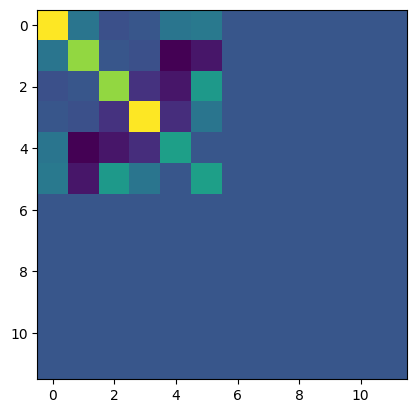

In [22]:


plt.imshow(model.rho_n.detach().numpy())
plt.show()

In [ ]:
v_ext=torch.diag(model.h)


print(model.rho_n.shape)
fock_operator=model.build_mixed_fock_matrix()
eigvals, unitary = torch.linalg.eigh(fock_operator)   # columns of U_can are eigenvectors


h_p, V_p = transform_integrals_full_unitary(U=unitary.T,h=model.h,V=model.V_tensor)
print(h_p)
plt.imshow(h_p.detach().numpy())
plt.show()

In [24]:
new_energies=np.diag(h_p.detach().numpy())
print(new_energies)

new_twobody_matrix={}
for a in range(size_a+size_b):
    for b in range(size_a+size_b):
        for c in range(size_a+size_b):
            for d in range(size_a+size_b):
                if np.abs(V_p[a,b,c,d].detach().numpy())>=10**-7:
                    new_twobody_matrix[(a,b,c,d)]=V_p[a,b,c,d].detach().numpy()

[1.72995887 1.72995887 1.75904291 1.75904291 1.76596756 1.76596756
 1.7377906  1.7377906  2.03407357 2.03407357 2.03316649 2.03316649]


In [25]:
print((new_twobody_matrix))
print(nparticles_b,nparticles_a)

{(0, 1, 0, 1): array(-3.77284697), (0, 1, 0, 4): array(0.80782775), (0, 1, 0, 5): array(-0.04850793), (0, 1, 0, 8): array(0.69948213), (0, 1, 0, 9): array(-0.10908016), (0, 1, 1, 0): array(3.77284697), (0, 1, 1, 4): array(-0.04850793), (0, 1, 1, 5): array(-0.80782775), (0, 1, 1, 8): array(0.10908016), (0, 1, 1, 9): array(0.69948213), (0, 1, 4, 0): array(-0.80782775), (0, 1, 4, 1): array(0.04850793), (0, 1, 4, 5): array(1.21077089), (0, 1, 4, 8): array(-0.14898187), (0, 1, 4, 9): array(-0.68329899), (0, 1, 5, 0): array(0.04850793), (0, 1, 5, 1): array(0.80782775), (0, 1, 5, 4): array(-1.21077089), (0, 1, 5, 8): array(-0.68329899), (0, 1, 5, 9): array(0.14898187), (0, 1, 8, 0): array(-0.69948213), (0, 1, 8, 1): array(-0.10908016), (0, 1, 8, 4): array(0.14898187), (0, 1, 8, 5): array(0.68329899), (0, 1, 8, 9): array(-1.62304634), (0, 1, 9, 0): array(0.10908016), (0, 1, 9, 1): array(-0.69948213), (0, 1, 9, 4): array(0.68329899), (0, 1, 9, 5): array(-0.14898187), (0, 1, 9, 8): array(1.62304

In [ ]:
NSMFockHamiltonian=FermiHubbardHamiltonian(size_a=size_a+size_b,size_b=0,nparticles_a=nparticles_a+nparticles_b,nparticles_b=0)
# one body term:
one_body_term=0.
for a in range(size_a+size_b):
    for b in range(size_a+size_b):
        one_body_term+=h_p[a,b].detach().numpy()*NSMFockHamiltonian.adag_a_matrix_optimized(a,b)


NSMFockHamiltonian.get_twobody_interaction_optimized(new_twobody_matrix)
NSMFockHamiltonian.get_hamiltonian()
NSMFockHamiltonian.hamiltonian+=one_body_term
egs,psigshf=NSMFockHamiltonian.get_spectrum(10)

print(egs)

In [32]:
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverterOnlynnpp

QPC=QuasiParticlesConverterOnlynnpp()
QPC.initialize_shell(state_encoding=SPS.state_encoding)
QPC.get_the_basis_matrix_transformation(NSMHamiltonian.basis)


QPCHF=QuasiParticlesConverterOnlynnpp()
QPCHF.initialize_shell(state_encoding=SPS.state_encoding)
QPCHF.get_the_basis_matrix_transformation(NSMFockHamiltonian.basis)

new_couples=[]
for i in range(0,size_a+size_b,2):
    new_couples.append([i,i+1])
    
    
QPCHF.couples=new_couples






In [35]:
print(QPC.quasiparticle_basis.shape)
hamiltonian_Q=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
egsQ,psi_Q=eigsh(hamiltonian_Q,k=8,which='SA')

hamiltonian_QHF=QPCHF.particles2quasiparticles @ NSMFockHamiltonian.hamiltonian @ QPCHF.particles2quasiparticles.T
egsQnp,psi_Qnp=eigsh(hamiltonian_QHF,k=5,which='SA')

print(egsQnp,egsQ)






print('\n')

#print(psigs[:,0].dot(psi_Q2particle.conj())*np.conjugate(psigs[:,0].dot(psi_Q2particle.conj())))
fs=[]
for i in range(egsQnp.shape[0]):
    psi_Qnp2particle=QPCHF.particles2quasiparticles.T @ psi_Qnp[:,i]
    psi_Qnp2particle/=np.linalg.norm(psi_Qnp2particle)
    print(psigshf[:,0].dot(psi_Qnp2particle.conj())*np.conjugate(psigshf[:,0].dot(psi_Qnp2particle.conj())))#,j_values[i])
    fs.append(psigshf[:,0].dot(psi_Qnp2particle.conj())*np.conjugate(psigshf[:,0].dot(psi_Qnp2particle.conj())))
print('\n')
print(np.sum(fs),'\n')
fs=[]
for i in range(egsQ.shape[0]):
    psi_Q2particle=QPC.particles2quasiparticles.T @ psi_Q[:,i]
    psi_Q2particle/=np.linalg.norm(psi_Q2particle)
    
    print(psigs[:,0].dot(psi_Q2particle.conj())*np.conjugate(psigs[:,0].dot(psi_Q2particle.conj())))#,j_values[0])
    fs.append(psigs[:,0].dot(psi_Q2particle.conj())*np.conjugate(psigs[:,0].dot(psi_Q2particle.conj())))
print('\n')
print(np.sum(fs))


(9, 6)
[-31.94107396 -31.0774131  -29.68452668 -21.73692519 -21.30850101] [-34.81247368 -30.81435701 -23.53412006 -23.15320199 -19.19077138
 -16.65267332 -16.40305021  -9.58037461]


3.572482104814458e-25
0.007819698061528898
3.526081229804093e-27
2.3283328556964685e-32
5.712634668663547e-33


0.007819698061528898 

0.8333627514297328
7.403274706224535e-31
2.246404687133272e-30
0.0024189608971884567
0.001817896426289909
4.437342591868191e-31
0.002167154506923893
2.034263503759018e-31


0.839766763260135
